# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 0.254  train_ave_acc: 0.551  (3.27s - 650.71s remaining) ave_loss: 0.2541562485729844 ave_acc: 0.5511945126944734
EPOCH: 2.000  train_ave_loss: 0.243  train_ave_acc: 0.591  (6.06s - 600.16s remaining) ave_loss: 0.24254286574347278 ave_acc: 0.5912737180927837
EPOCH: 3.000  train_ave_loss: 0.240  train_ave_acc: 0.605  (8.86s - 581.49s remaining) ave_loss: 0.239557632581055 ave_acc: 0.6045023072418595
EPOCH: 4.000  train_ave_loss: 0.237  train_ave_acc: 0.604  (11.64s - 570.48s remaining) ave_loss: 0.23680094607676927 ave_acc: 0.6038761285288992
EPOCH: 5.000  train_ave_loss: 0.233  train_ave_acc: 0.629  (14.42s - 562.43s remaining) ave_loss: 0.23287666138927957 ave_acc: 0.6286785695477001
EPOCH: 6.000  train_ave_loss: 0.227  train_ave_acc: 0.622  (17.22s - 556.81s remaining) ave_loss: 0.22689211519183783 ave_acc: 0.6224999420894618
EPOCH: 7.000  train_ave_loss: 0.222  train_ave_acc: 0.621  (20.01s - 551.63s remaining) ave_loss: 0.22248010294473677 ave_acc: 0.6

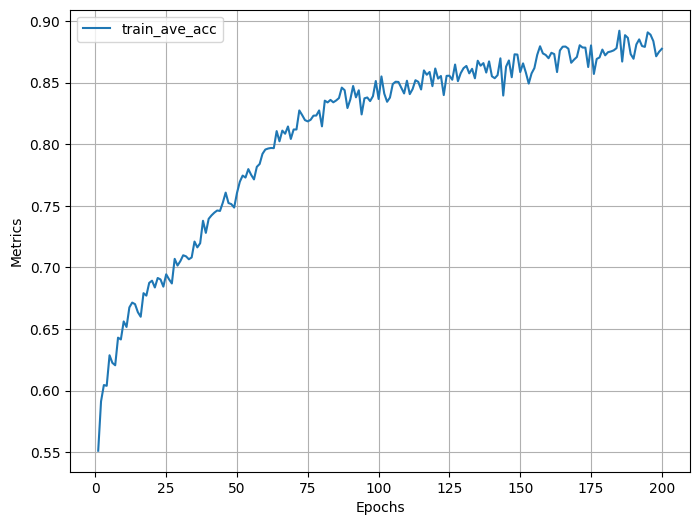

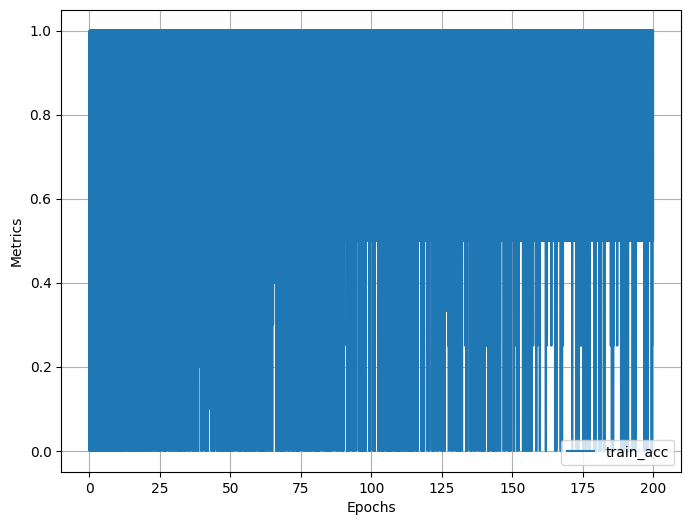

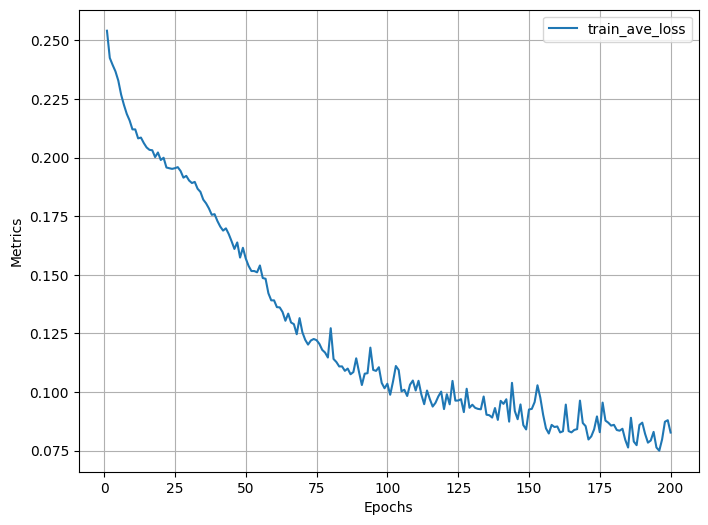

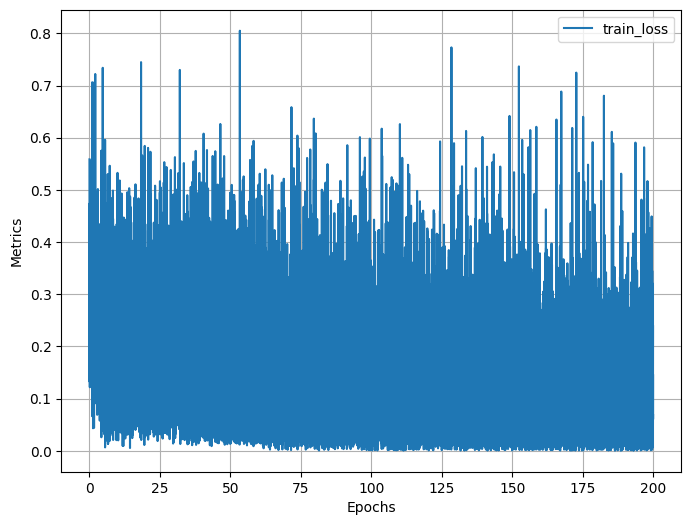

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.5511221945137157
NN MC MSE: 0.33526941509326935
NN MC Seq Accuracy: 0.6172069825436409
NN MC Seq MSE: 0.3207292246055513


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 0.164  train_ave_acc: 0.506  (2.56s - 509.38s remaining) ave_loss: 0.16449942556687813 ave_acc: 0.5055729346582487
EPOCH: 2.000  train_ave_loss: 0.142  train_ave_acc: 0.531  (5.12s - 506.88s remaining) ave_loss: 0.14249714355795615 ave_acc: 0.5308275587445399
EPOCH: 3.000  train_ave_loss: 0.136  train_ave_acc: 0.537  (7.70s - 505.40s remaining) ave_loss: 0.13626796405358224 ave_acc: 0.5365827122985549
EPOCH: 4.000  train_ave_loss: 0.131  train_ave_acc: 0.555  (10.25s - 502.23s remaining) ave_loss: 0.13094580186055726 ave_acc: 0.5548679221389131
EPOCH: 5.000  train_ave_loss: 0.128  train_ave_acc: 0.572  (12.80s - 499.20s remaining) ave_loss: 0.12820588660227064 ave_acc: 0.5719256588257119
EPOCH: 6.000  train_ave_loss: 0.128  train_ave_acc: 0.549  (15.37s - 496.80s remaining) ave_loss: 0.1280346770342057 ave_acc: 0.5487299999361711
EPOCH: 7.000  train_ave_loss: 0.095  train_ave_acc: 0.596  (18.07s - 498.08s remaining) ave_loss: 0.09450668757207845 ave_acc: 0

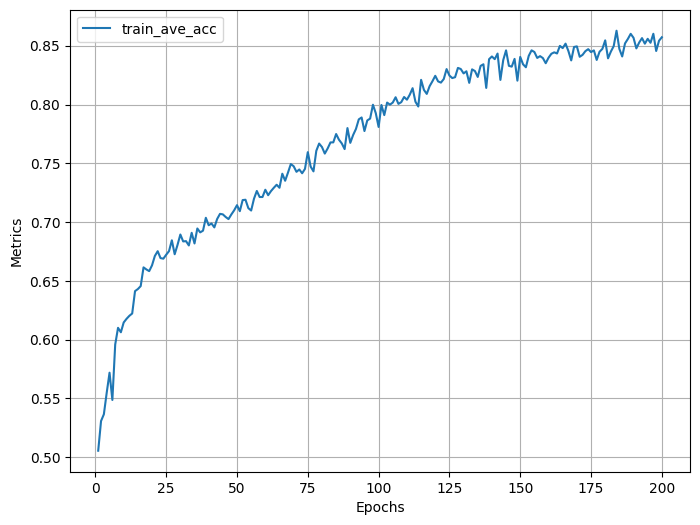

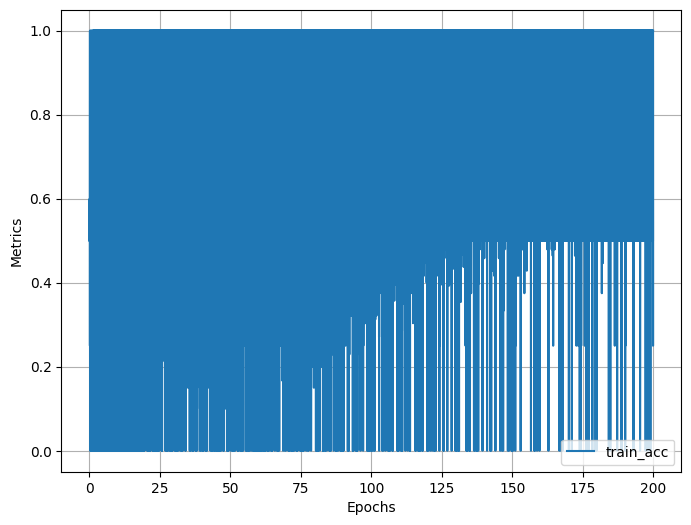

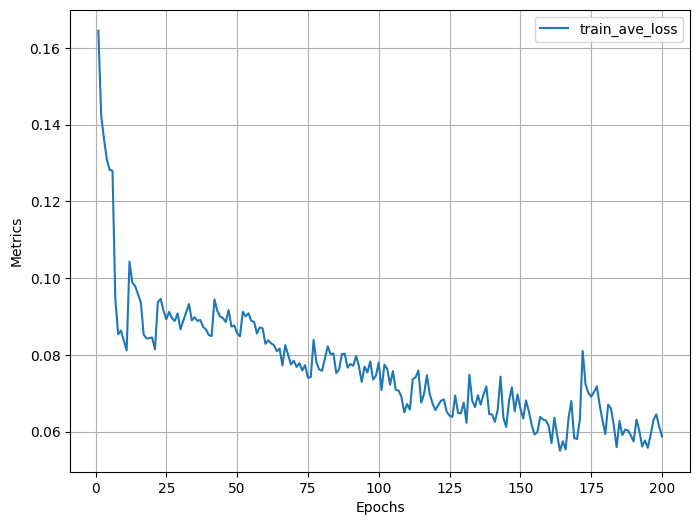

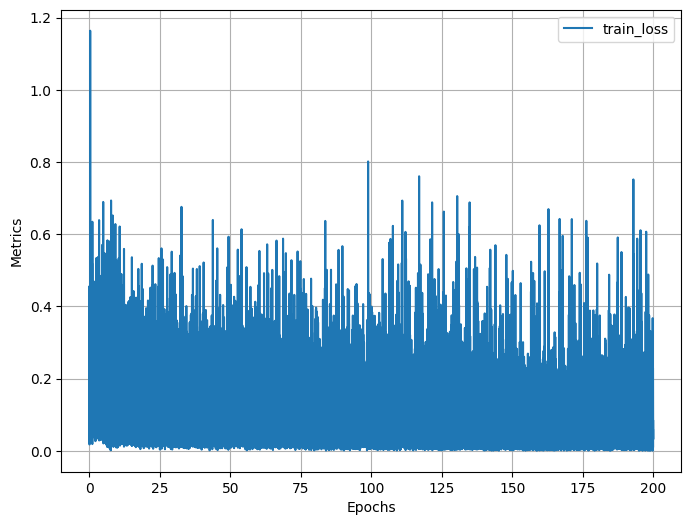

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.5586034912718204
NN Sarsa MSE: 0.30540698097908553
NN Sarsa Seq Accuracy: 0.6109725685785536
NN Sarsa Seq MSE: 0.2817196364351196


#### Training (With MC Init)

In [9]:
import d_sarsa

nn_mc_state_dict = nn_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict)

Init state dictionary was passed. Using that to initialize model_net.
EPOCH: 1.000  train_ave_loss: 0.080  train_ave_acc: 0.872  (2.70s - 537.94s remaining) ave_loss: 0.08007268116965104 ave_acc: 0.871808704987664
EPOCH: 2.000  train_ave_loss: 0.075  train_ave_acc: 0.861  (5.36s - 530.79s remaining) ave_loss: 0.07528305158655424 ave_acc: 0.8608624353601801
EPOCH: 3.000  train_ave_loss: 0.067  train_ave_acc: 0.874  (8.04s - 528.19s remaining) ave_loss: 0.06719980860549596 ave_acc: 0.8737524107948136
EPOCH: 4.000  train_ave_loss: 0.069  train_ave_acc: 0.863  (10.73s - 525.66s remaining) ave_loss: 0.06935324784794336 ave_acc: 0.863205673529061
EPOCH: 5.000  train_ave_loss: 0.065  train_ave_acc: 0.861  (13.37s - 521.50s remaining) ave_loss: 0.0650403829860908 ave_acc: 0.8610126996809656
EPOCH: 6.000  train_ave_loss: 0.075  train_ave_acc: 0.849  (16.02s - 518.13s remaining) ave_loss: 0.07509810702712753 ave_acc: 0.8494712049567117
EPOCH: 7.000  train_ave_loss: 0.071  train_ave_acc: 0.856  (

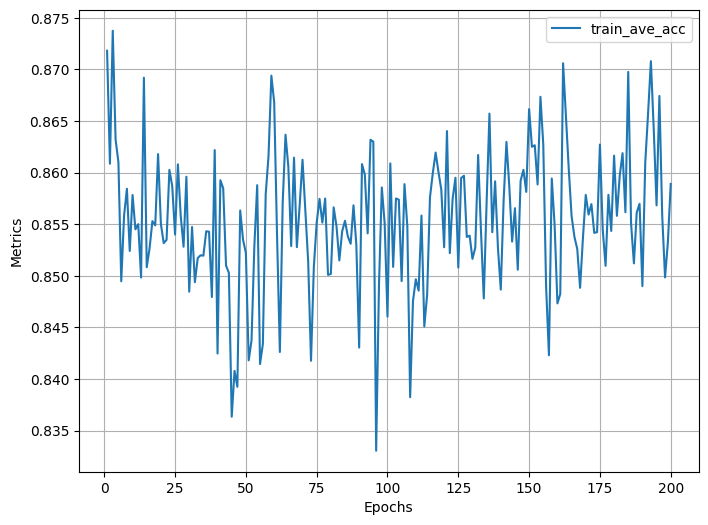

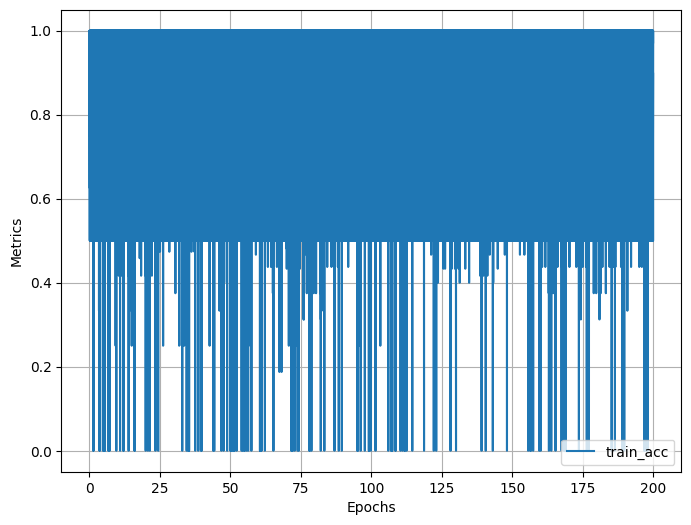

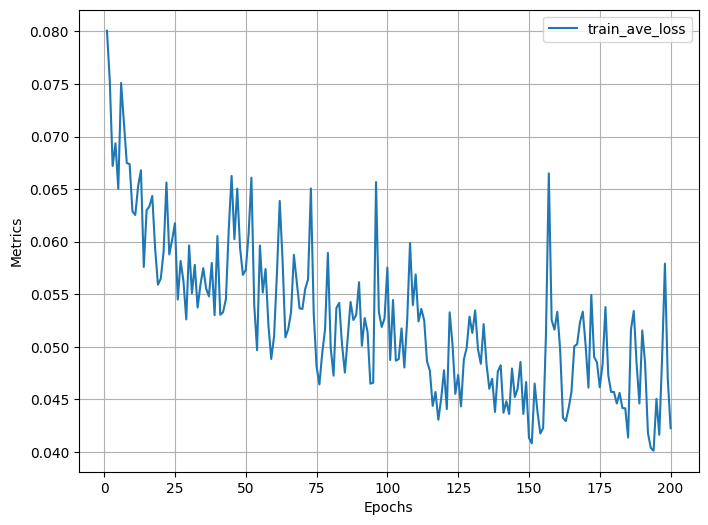

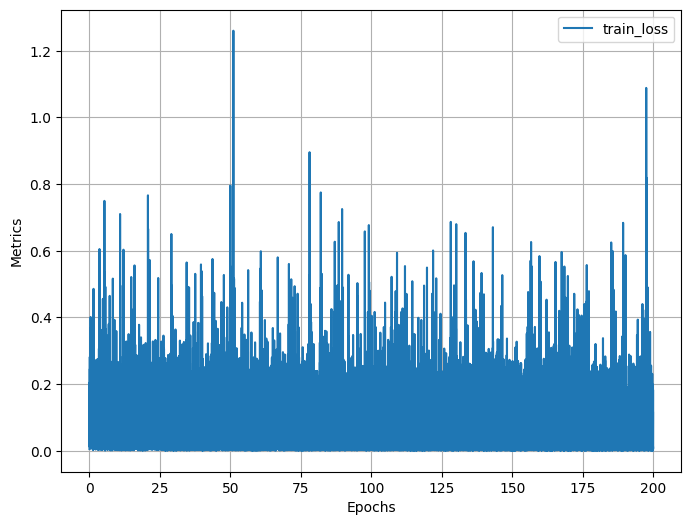

In [10]:
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [11]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

NN Sarsa With MC Init Accuracy: 0.527431421446384
NN Sarsa With MC Init MSE: 0.30701007787528595
NN Sarsa With MC Init Seq Accuracy: 0.6209476309226932
NN Sarsa With MC Init Seq MSE: 0.270860176596634


In [12]:
import os

model_dirpath = 'experiment_models/200epoch_7e-4lr_vanilla_paper_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Conclusion

### Summary

### Future extensions